In [1]:
import os
import re
import random
from PIL import Image
from collections import defaultdict
import ast

import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
import spacy
import nltk
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator


In [4]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

OFFERS_PATH = "data/extracted_sellers_old.json"
languages = [("en", "pl"), ["en"], ["pl"]]

pl_nlp = spacy.load('pl_core_news_sm')
en_nlp = spacy.load('en_core_web_sm')

sns.set_theme()
try:
    Language.factory("language_detector", func=get_lang_detector)
except ValueError:
    pass

en_nlp.add_pipe('language_detector', last=True)
df = pd.read_json(OFFERS_PATH)
df["description"] = df["description"].str.replace("About This Gig ", "")


In [ ]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
with open("stopwords/polish_stopwords.txt") as file:
    pl_stopwords: list = file.readlines()

pl_stop = set(pl_stopwords)
en_stop = set(stopwords.words("english"))
languages = [["en"]]
def detect_language(document) -> str:
    doc = en_nlp(document)
    detect_language = doc._.language
    return(detect_language["language"])

def preprocess_html(document):
    # Remove all the special characters
    document = re.sub(r"\W", " ", str(document))

    # remove all single characters
    document = re.sub(r"\s+[a-zA-Z]\s+", " ", document)

    # Remove single characters from the start
    document = re.sub(r"\^[a-zA-Z]\s+", " ", document)

    # Substituting multiple spaces with single space
    document = re.sub(r"\s+", " ", document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r"^b\s+", "", document)

    return document


def preprocess_text(document):
    document = preprocess_html(document)

    lang = detect_language(document)

    if lang == "pl":
        doc = pl_nlp(document)
        tokens = [word.lemma_ for word in doc]
        tokens = [word for word in tokens if word not in pl_stop]

    else:
        doc = en_nlp(document)
        tokens = [word.lemma_ for word in doc]
        tokens = [word for word in tokens if word not in en_stop]


    return tokens, lang



[nltk_data] Downloading package punkt to /home/patryk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/patryk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/patryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# tqdm.pandas()
# df["description_lem"], df["language"] = zip(*df["description"].progress_apply(lambda x: preprocess_text(x)))

# df.to_csv("out/sellers_extracted_lem.csv")

In [5]:
# df.to_csv("out/extracted_sellers_lem.csv")

In [6]:
df = pd.read_csv("out/extracted_sellers_lem.csv")
df["description_lem"] = df["description_lem"].apply(lambda x: ast.literal_eval(x))
df["skills"] = df["skills"].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else [])

# Ile sprzedawców z jakiego języka?

In [22]:
df["language"].iloc[1]

'en'

# Rozkład długości tekstów

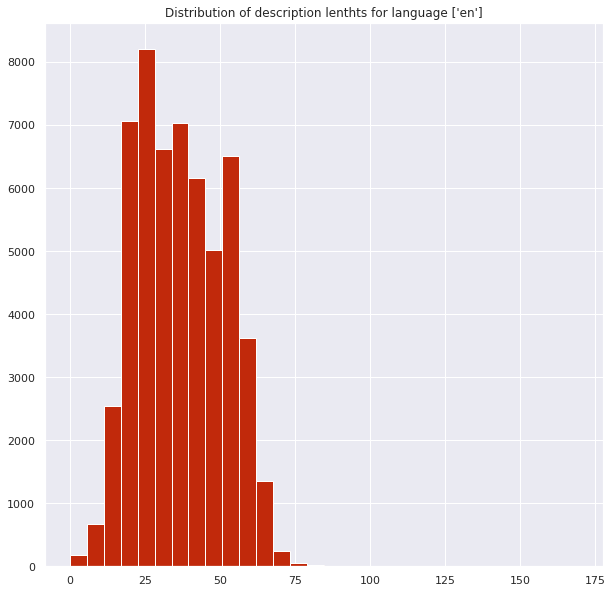

In [8]:
for lang in languages:
    tokens = [len(row) for row in df[df["language"].isin(lang)]["description_lem"]]
    plt.figure(figsize=(10, 10))
    plt.title(f"Distribution of description lenthts for language {lang}")
    plt.hist(tokens, bins=30, color="#c1290b")

In [9]:
df["description_lem"]

0        [I, passionate, content, writer, write, resear...
1        [I, professional, graphic, designer, 5, year, ...
2        [name, sami, bassalem, 23, year, old, active, ...
3        [I, geek, passionate, innovation, business, wo...
4        [hello, everyone, Artist, Illustrator, Digital...
                               ...                        
56078    [I, handful, experience, work, AdRoll, tool, m...
56079    [hi, Beulah, one, fast, friendly, versatile, f...
56080    [I, Brand, Packaging, Specialist, experience, ...
56081    [ , Yuriy, succeed, three, crowdfunde, campaig...
56082    [hi, Vlad, experienced, designer, illustrator,...
Name: description_lem, Length: 56083, dtype: object

In [10]:
df.head(1)

,Unnamed: 0,name,description,languages,skills,education,description_lem,language
0,0,oyuchi,I am a passionate content writer. I have writt...,['English - Basic'],"[Typewriting, Data entry, Microsoft Word, Typi...","['B.Sc. - nursing Nairobi University, Kenya, G...","[I, passionate, content, writer, write, resear...",en


# N-GRAMS

<Figure size 432x288 with 0 Axes>

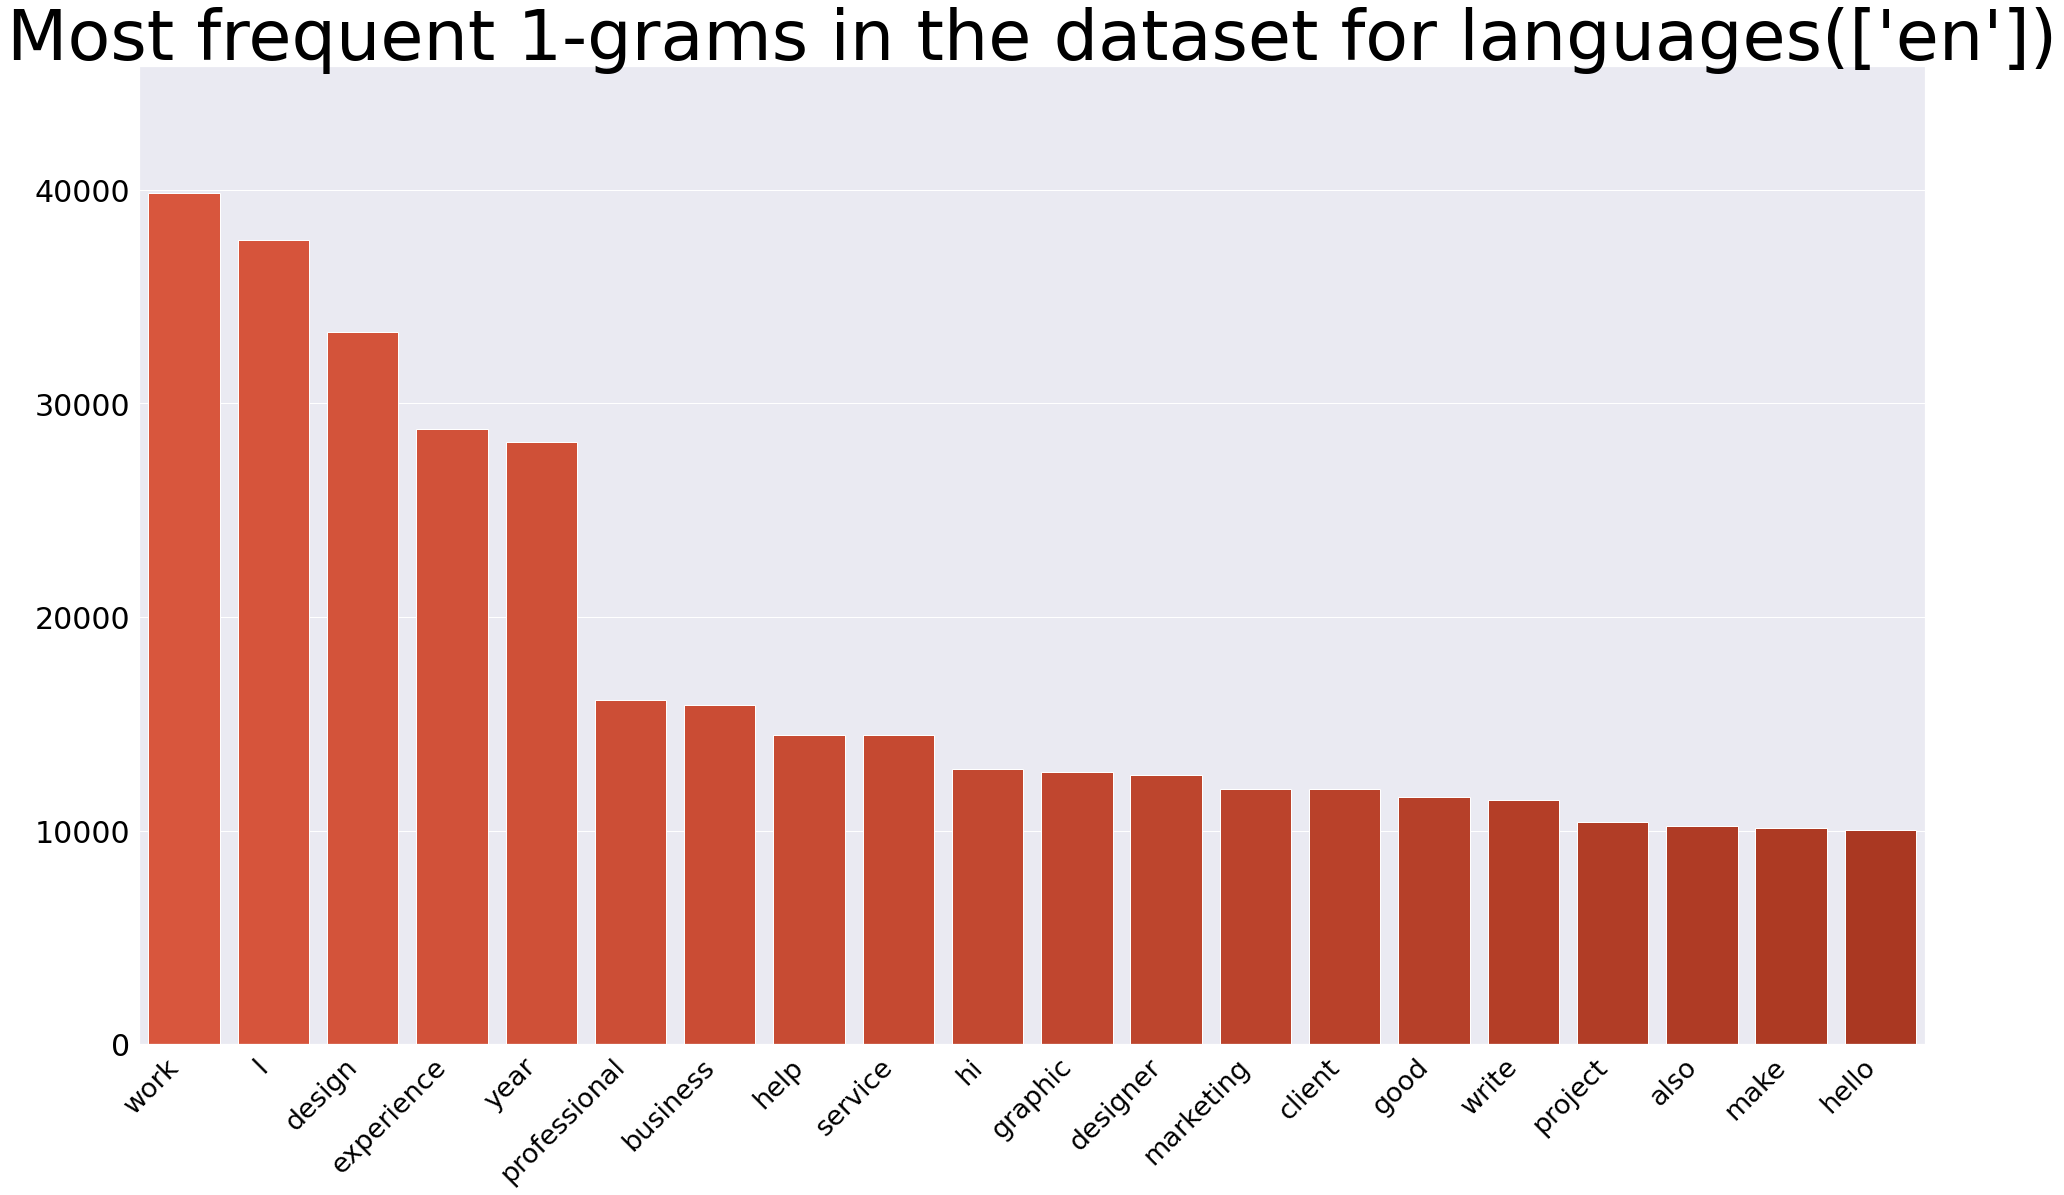

<Figure size 432x288 with 0 Axes>

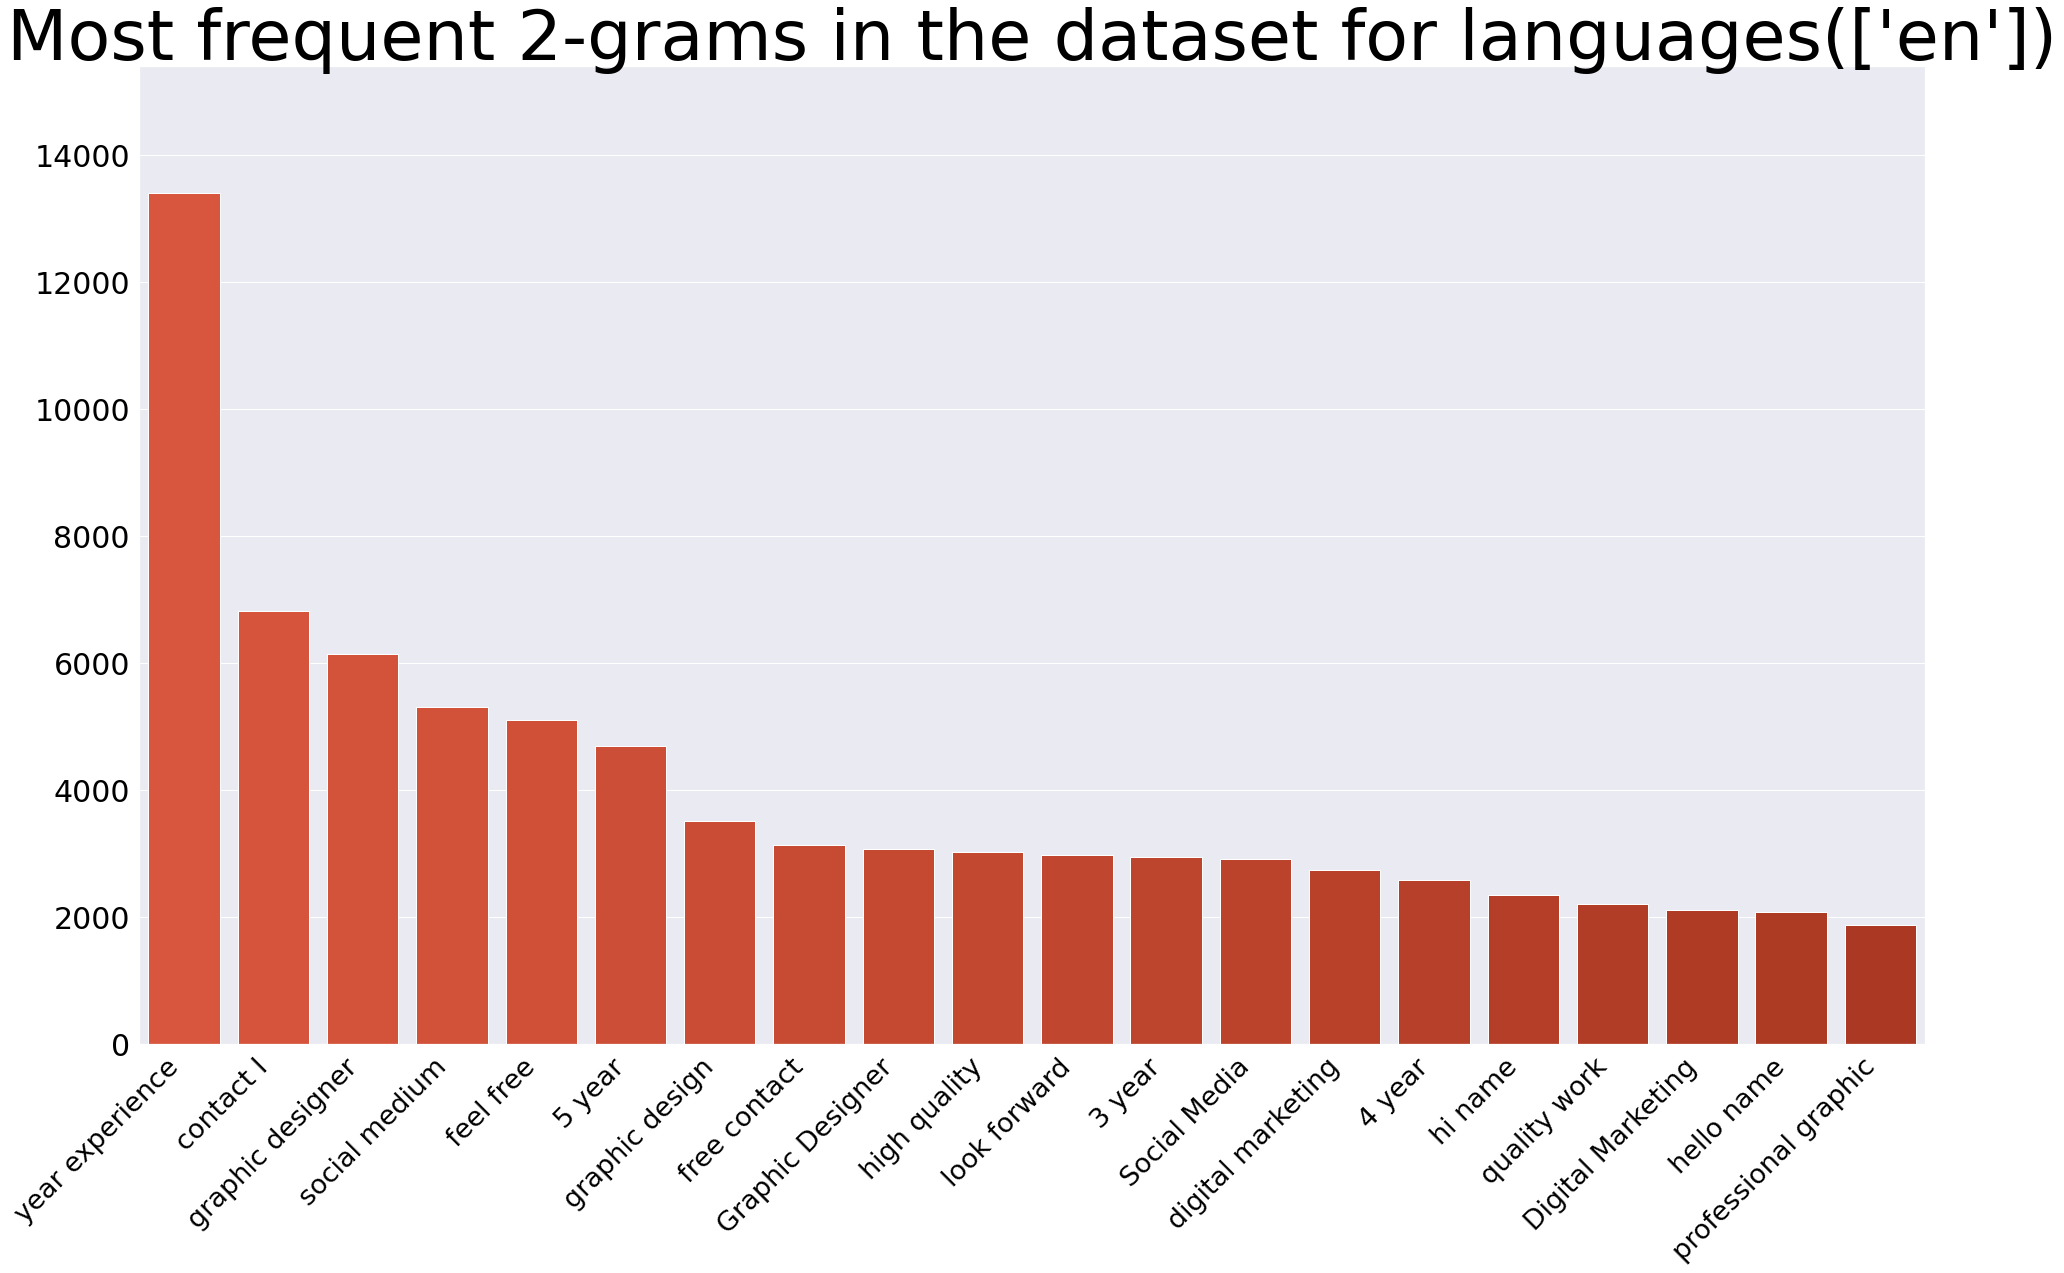

<Figure size 432x288 with 0 Axes>

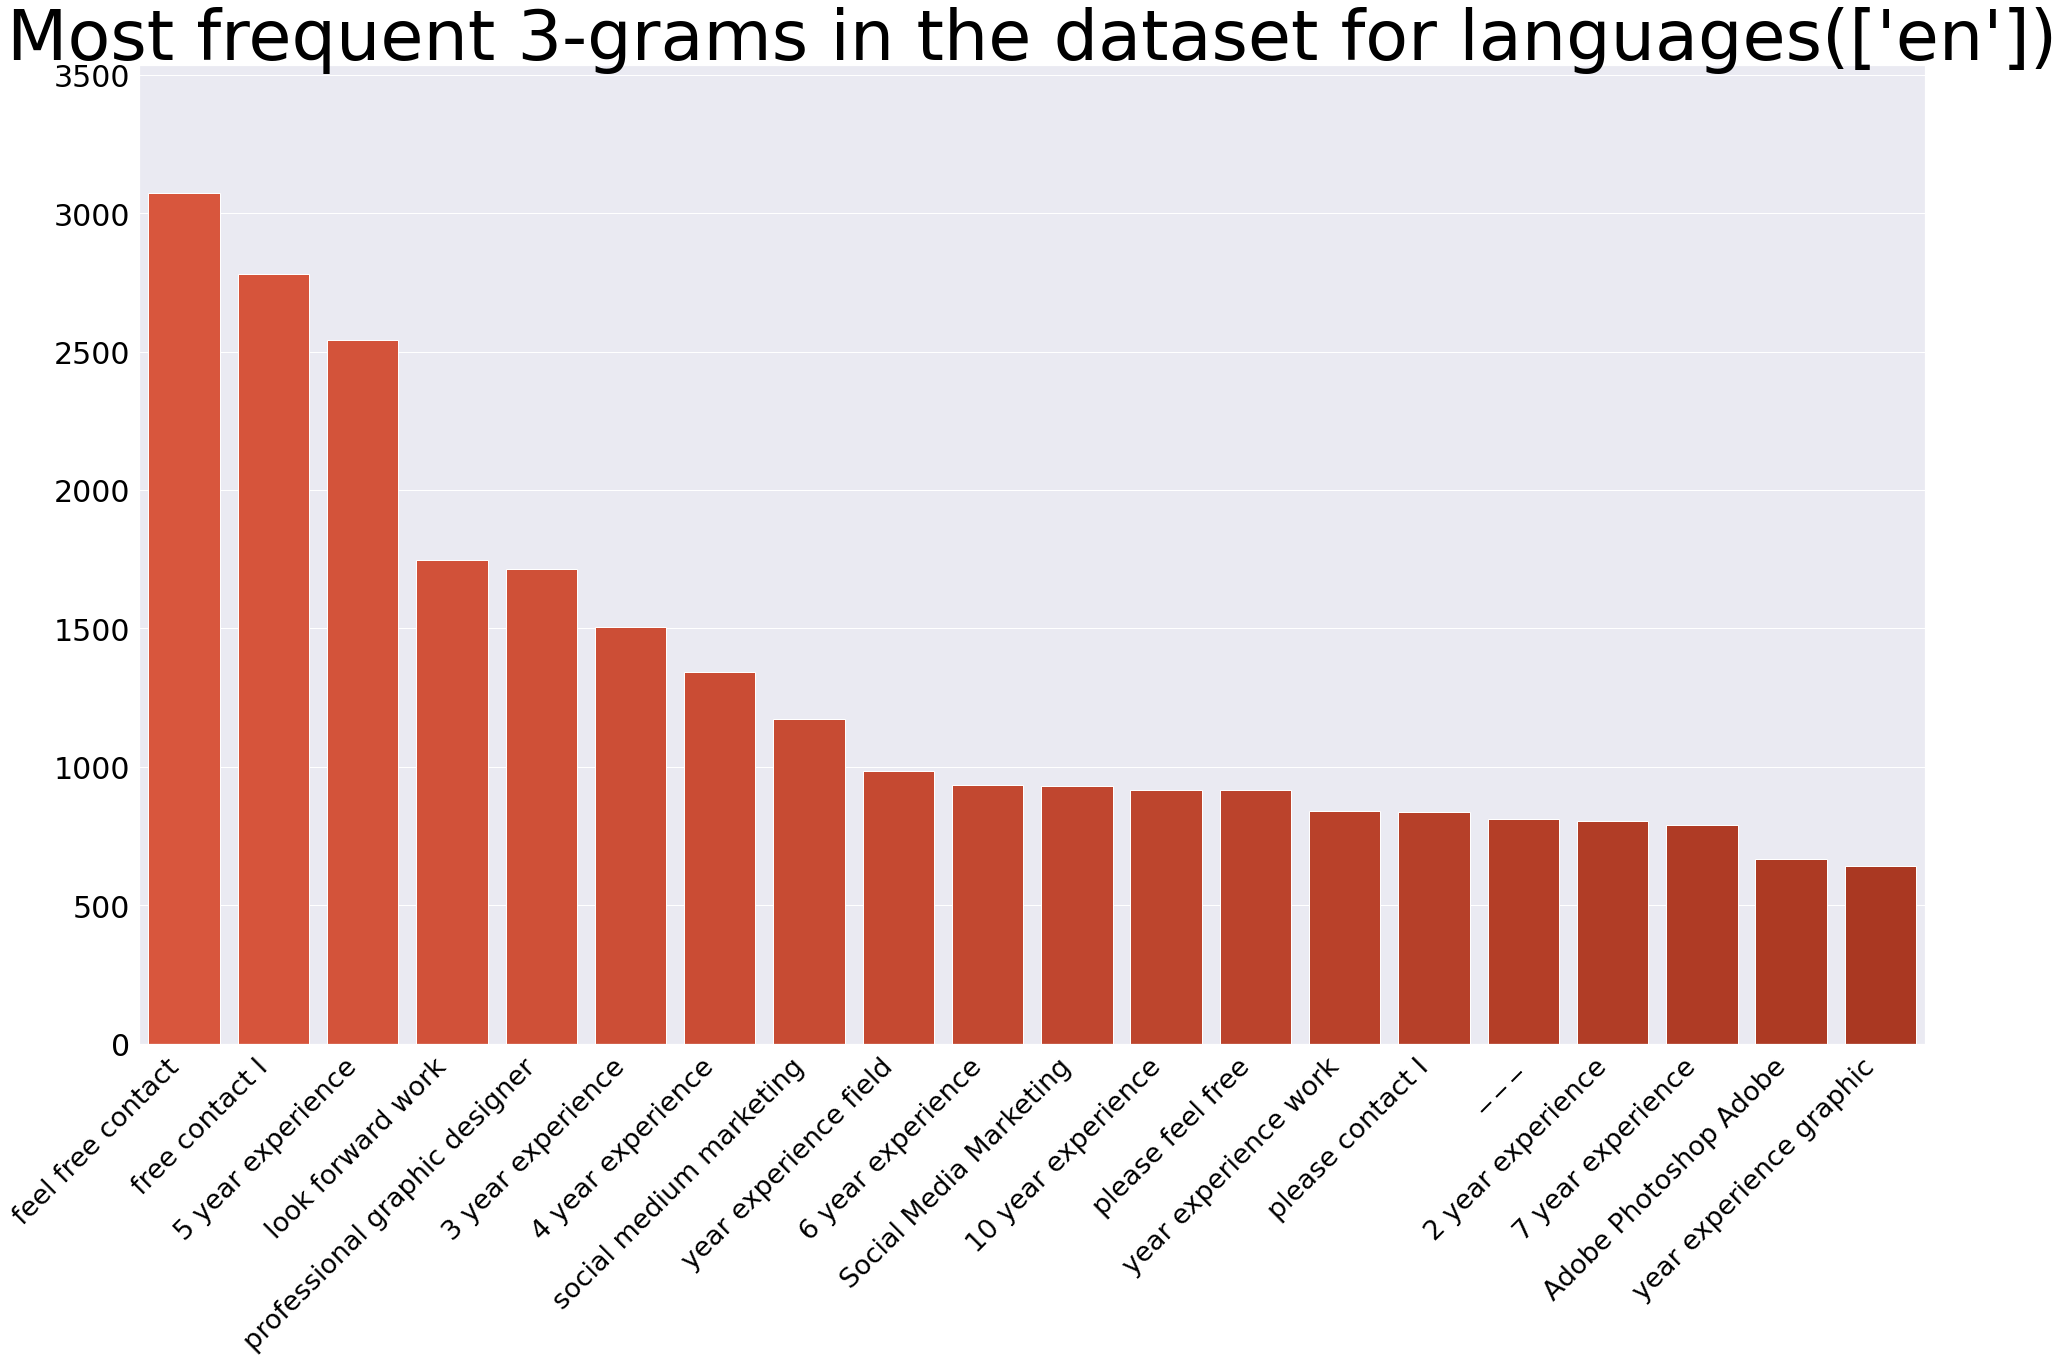

In [11]:
n_grams = [1, 2, 3]

for lang in languages:
    for n_gram in n_grams:

        tokens = [word for row in df[df["language"].isin(lang)]["description_lem"] for word in row]

        grams_2 = nltk.ngrams(tokens, n_gram)
        freq_2 = nltk.FreqDist(grams_2)
        data = [{" ".join(gram): freq} for (gram, freq) in freq_2.items()]
        data.sort(key=lambda x: -list(x.values())[0])

        keys = np.array([list(item.keys())[0] for item in data])[:20]
        values = np.array([list(item.values())[0] for item in data])[:20]

        order = np.argsort(values)[::]

        for i in [18]:
            plt.figure()
            sns.set_theme()
            # COLOR = 'white'
            COLOR = 'black'
            mpl.rcParams['text.color'] = COLOR
            mpl.rcParams['axes.labelcolor'] = COLOR
            mpl.rcParams['xtick.color'] = COLOR
            mpl.rcParams['ytick.color'] = COLOR
            pal_red = sns.color_palette('blend:#f24423,#c1290b', len(keys))
            fig = plt.figure(figsize=(32, i))
            graph = sns.barplot(x = keys, y = values, palette= np.array(pal_red[::-1])[order])
            graph.set_title(f"Most frequent {n_gram}-grams in the dataset for languages({lang})", fontsize=70)
            ax = plt.gca()
            plt.ylim(0, max(values) + 0.15*max(values)) 
            # ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
            ax.tick_params(axis='y', which='major', labelsize=30)
            graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=27)
            # plt.savefig(f"words_32_{i}.png", transparent=True, dpi=300)
            plt.show()


# Wordclouds

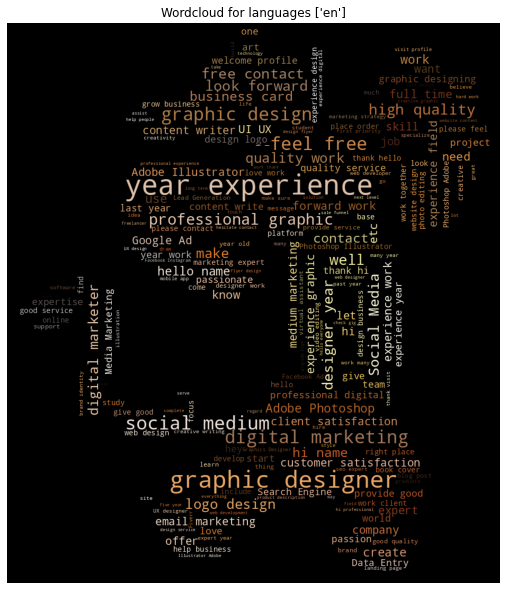

In [12]:
for lang in languages:
    
    background_image = np.array(Image.open('../img/tygrysek.jpg'))
    img_colors = ImageColorGenerator(background_image)

    wordcloud = WordCloud(
        width=3000,
        height=2400,
        background_color="black",
        mask=background_image,
        color_func=img_colors
        # color_func = grey_color_func
    ).generate(" ".join([" ".join(row) for row in df[df["language"].isin(lang)]["description_lem"]]))

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.title(f"Wordcloud for languages {lang}")
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # plt.savefig("wordcloud.png", dpi=300)

In [13]:
df.head(1)

,Unnamed: 0,name,description,languages,skills,education,description_lem,language
0,0,oyuchi,I am a passionate content writer. I have writt...,['English - Basic'],"[Typewriting, Data entry, Microsoft Word, Typi...","['B.Sc. - nursing Nairobi University, Kenya, G...","[I, passionate, content, writer, write, resear...",en


In [14]:
df["skills"][0]

['Typewriting',
 'Data entry',
 'Microsoft Word',
 'Typing',
 'Editing',
 'Content writing']

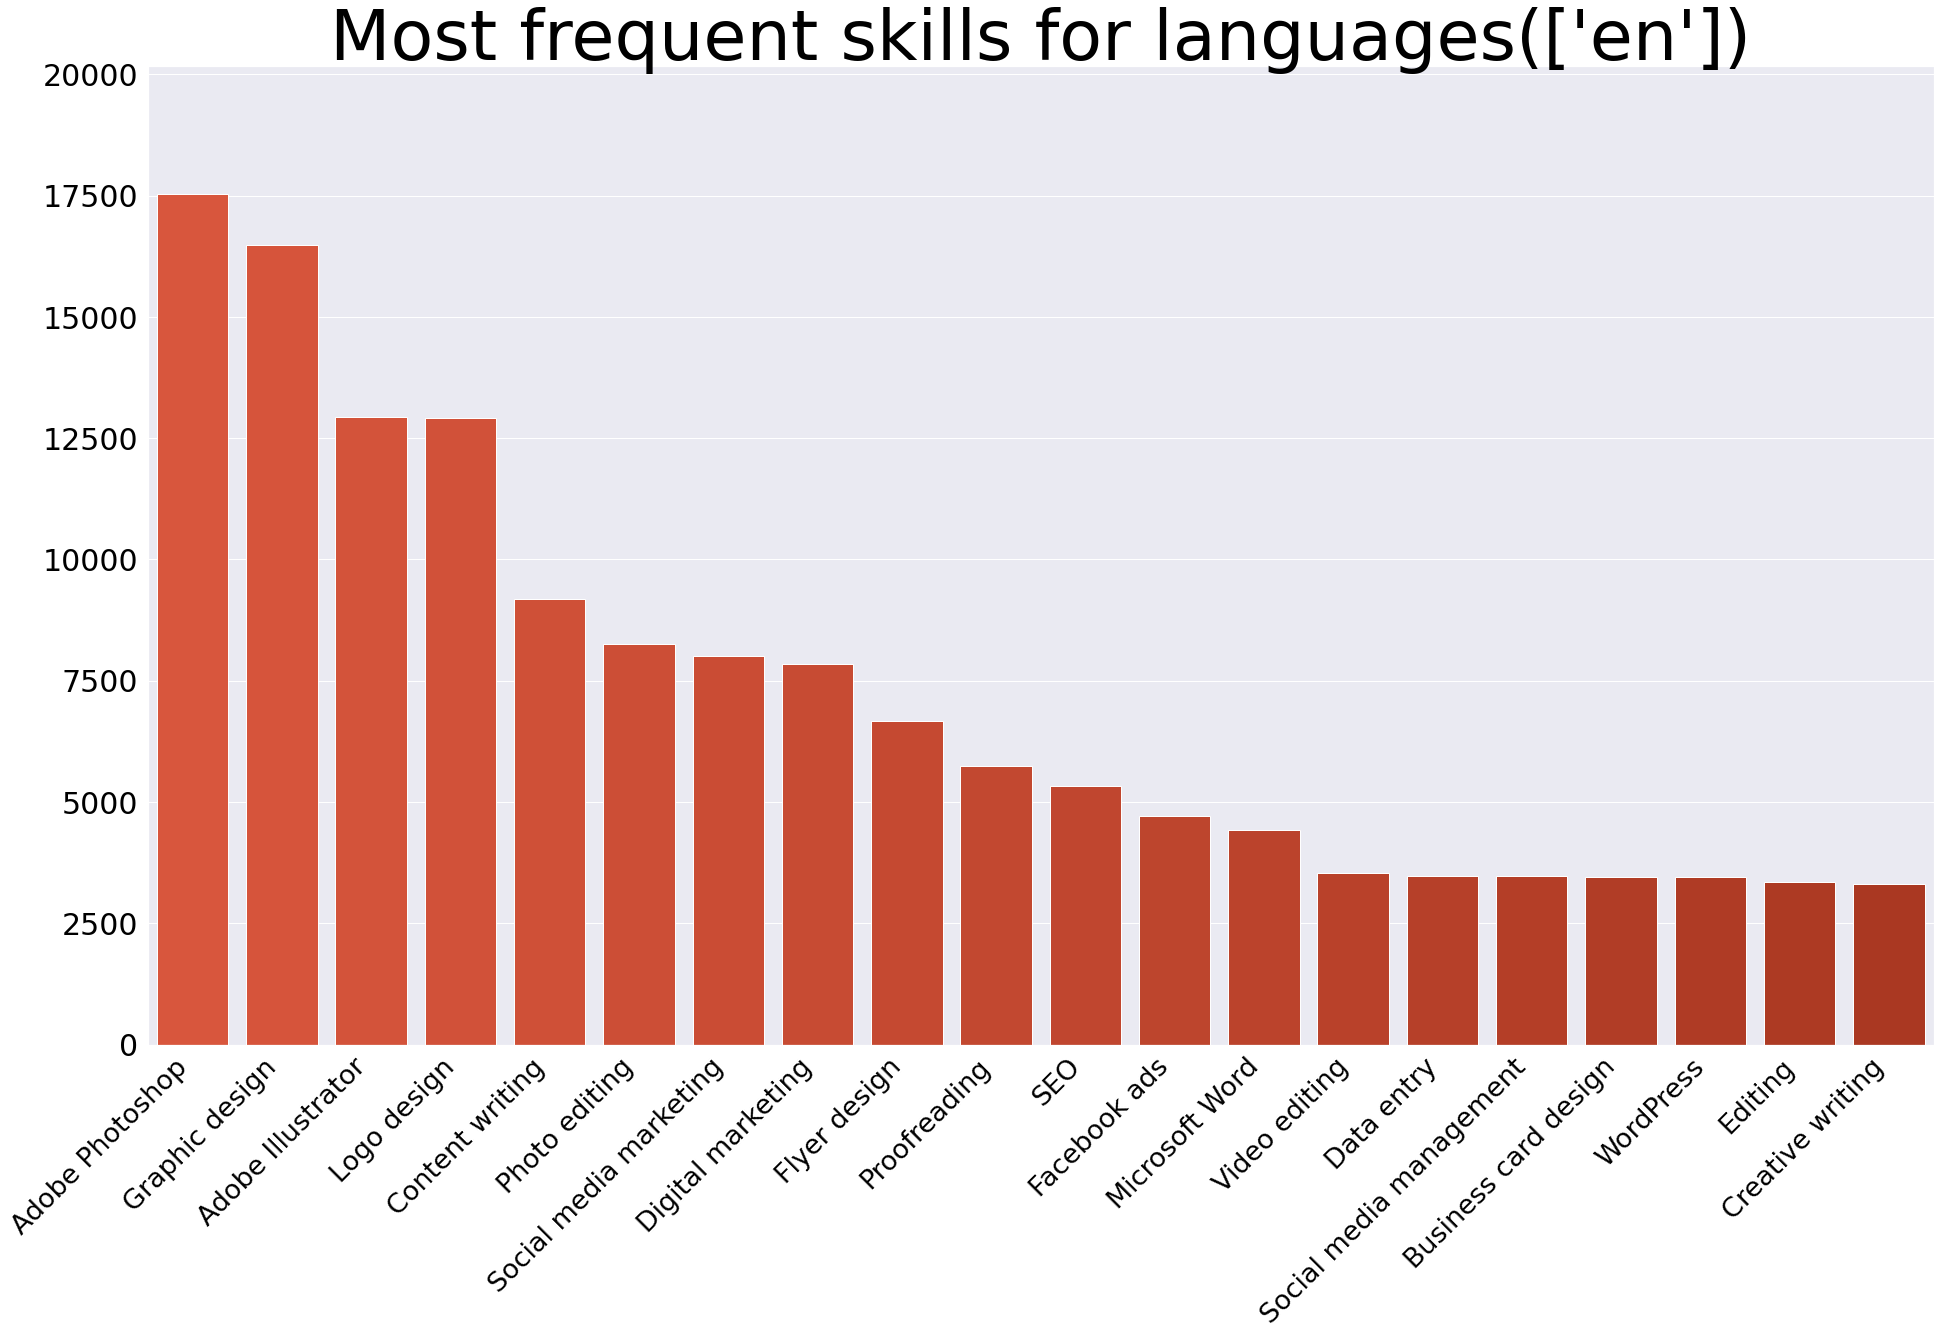

In [15]:
skills_dict: dict = defaultdict(lambda: defaultdict(lambda: 0))
for lang in languages:
    for skills in df[df["language"].isin(lang)]["skills"]:
        if skills:
            for skill in skills:
                skills_dict[str(lang)][skill] += 1


    skills = {k: v for k, v in sorted(skills_dict[str(lang)].items(), key=lambda item: -item[1])}

    keys, values = zip(*sorted(skills_dict[str(lang)].items(), key=lambda item: -item[1])[:20])
    keys = np.array(keys)
    values = np.array(values)


    pal_red = sns.color_palette('blend:#f24423,#c1290b', len(values))
    fig = plt.figure(figsize=(32, 18))
    graph = sns.barplot(x = keys, y = values, palette= np.array(pal_red[::])[range(len(values))])
    graph.set_title(f"Most frequent skills for languages({lang})", fontsize=70)
    ax = plt.gca()
    plt.ylim(0, max(values) + 0.15*max(values)) 
    # ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
    ax.tick_params(axis='y', which='major', labelsize=30)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=27)
    # plt.savefig(f"words_32_{i}.png", transparent=True, dpi=300)
    plt.show()

In [16]:
import json

skills = defaultdict(lambda: 0)

for k, v in skills_dict["['en']"].items():
    skills[k.lower()] += v
skills = {k: v for k, v in sorted(skills.items(), key=lambda item: -item[1])}
with open("skills_fiverr.json", "w", encoding="utf-8") as file:
    json.dump(skills, file, ensure_ascii=False)

In [17]:
skills

{'adobe photoshop': 17540,
 'graphic design': 16480,
 'adobe illustrator': 12929,
 'logo design': 12909,
 'content writing': 9193,
 'photo editing': 8265,
 'social media marketing': 8003,
 'digital marketing': 7842,
 'flyer design': 6679,
 'proofreading': 5741,
 'seo': 5332,
 'facebook ads': 4708,
 'microsoft word': 4430,
 'video editing': 3545,
 'data entry': 3480,
 'social media management': 3480,
 'business card design': 3459,
 'wordpress': 3454,
 'editing': 3360,
 'creative writing': 3308,
 'email marketing': 3271,
 'typing': 3095,
 'illustration': 3073,
 'banner design': 2628,
 'microsoft powerpoint': 2575,
 'writing': 2563,
 'microsoft excel': 2559,
 'blog writing': 2461,
 'microsoft office': 2250,
 'website design': 2207,
 'copywriting': 2142,
 'brochure design': 2048,
 '3d modelling': 1908,
 'poster design': 1704,
 'web development': 1680,
 'web design': 1620,
 'virtual assistance': 1543,
 'photography': 1531,
 'social media design': 1523,
 '3d rendering': 1511,
 'photoshop edi

In [30]:
df[df["language"].isin(["en"])]["skills"].to_json("skills_fiverr_per_offer.json", force_ascii=False)

In [32]:
pd.read_json("skills_fiverr_per_offer.json")

TypeError: read_json() got an unexpected keyword argument 'force_ascii'